In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import torchvision.models as models
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import pickle

from pruner import * 
from models import *
from norbloader import *
from stanford_dogs import *

In [2]:
device = 'cuda:0'
TRAIN_BATCH_SIZE = 128*4
TEST_BATCH_SIZE=128*4

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = StanfordDOGS(root='./stanford-dogs', train=True, download=True, 
                        transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE,
                                         shuffle=True, num_workers=4)

testset = StanfordDOGS(root='./stanford-dogs', train=False, download=True, 
                       transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=TEST_BATCH_SIZE,
                                         shuffle=False, num_workers=4)

# trainset = NORB(root='./norb-data/', transform=transform_train, train=True)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE,
#                                          shuffle=True, num_workers=2)

# testset = NORB(root='./norb-data/', transform=transform_test, train=False)
# testloader = torch.utils.data.DataLoader(testset, batch_size=TEST_BATCH_SIZE,
#                                          shuffle=True, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [11]:
net = torchvision.models.resnet50(pretrained=True)
net = nn.DataParallel(net)
net = net.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ec2-user/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 95482911.36it/s]


In [12]:
# net.load_state_dict(torch.load('./checkpoints/iterative-pruning-cifar10/test-all-2-1-reinit-trained'))
# pruner_save = pickle.load(open('./experiment_data/iterative-pruning-cifar10/test-all-2-1.p', 'rb'))
# pruner = SparsityPruner(net)
# pruner.masks = pruner_save.masks
# pruner.apply_mask(prune_global=True)

In [13]:
train_losses, val_losses, train_accs, val_accs = [], [], [], []
N_EPOCH=50
LOG=25

def get_lr(epoch):
    if (epoch+1) >= 150:
        return 1e-3
    elif (epoch+1) >= 100:
        return 5e-3
    return 1e-2

criterion = nn.CrossEntropyLoss()

for epoch in range(N_EPOCH):  # loop over the dataset multiple times
    print('Starting epoch {}'.format(epoch+1))
    net.train()
    optimizer = optim.SGD(net.parameters(), lr=get_lr(epoch), momentum=0.9, weight_decay=1e-4)
    for batch_idx, (inputs, labels) in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    #Validation
    net.eval()
    tcorrect = 0.
    running_loss = 0.
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(testloader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            # print(outputs.device)
            predictions = outputs.argmax(dim=1)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            bcorrect = labels.eq(predictions).sum()
            tcorrect += bcorrect.item()
    acc = tcorrect/(len(testloader)*testloader.batch_size)
    avg_loss = running_loss/len(testloader)
    print(acc, avg_loss)

Print('Done')

Starting epoch 1
0.14131433823529413 3.846773357952342
Starting epoch 2
0.5404411764705882 1.6495511111091166
Starting epoch 3
0.658203125 1.2024652011254255
Starting epoch 4
0.681640625 1.0837683642611784
Starting epoch 5
0.7188648897058824 0.9548151387887842
Starting epoch 6
0.7326516544117647 0.8815203905105591
Starting epoch 7
0.7290900735294118 0.8879278793054468
Starting epoch 8
0.7478170955882353 0.8263524770736694
Starting epoch 9
0.7387408088235294 0.8685697895639083
Starting epoch 10
0.7494255514705882 0.8285503106958726
Starting epoch 11
0.7621783088235294 0.8047388318706962
Starting epoch 12
0.7596507352941176 0.8102492707617143
Starting epoch 13
0.7489659926470589 0.839573975871591
Starting epoch 14


KeyboardInterrupt: 

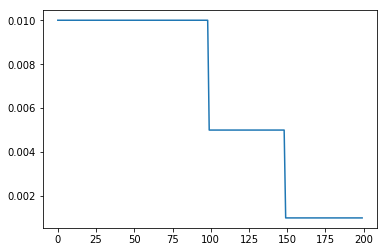

In [10]:
x = np.arange(0,200)
y = [get_lr(y) for y in x]
plt.plot(x, y)

In [67]:
net.test()

(0.8496907552083334, 1.2844280811647575)

In [68]:
save_data = {'train_losses': train_losses, 
            'val_losses': val_losses, 
            'train_accs': train_accs, 
            'val_accs': val_accs}
pd.DataFrame(save_data).to_csv('./experiment_data/iterative-pruning-cifar10/norb-transfer-1.csv')

In [7]:
len(testset)

8580